In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

In [2]:
country_data_path = '../Data/country_data'
macro_data_path = '../Data/macro_factors'
cluster_path = '../Outputs/country_clusters'

## Load Data

### Read country sovereign bond index data

In [3]:
ticker = pd.read_excel(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_data.xlsx'), sheet_name='ticker mapping')

In [4]:
ticker['Country'] = ticker['Index Name'].apply(lambda x:' '.join(x.split()[4:-2]))

In [5]:
ticker['Index Full Name'] = ticker['Index'] + ' Index'

In [6]:
ticker[['Index Full Name', 'Country']].head()

,Index Full Name,Country
0,GDDZ Index,Algeria
1,GDAO Index,Angola
2,GDAR Index,Argentina
3,GDAM Index,Armenia
4,GDAW Index,Aruba


In [7]:
ticker['Country'].unique()

array(['Algeria', 'Angola', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Barbados', 'Belarus', 'Belize', 'Bolivia',
       'Brazil', 'Bulgaria', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Fiji', 'Gabon', 'Georgia', 'Ghana', 'Greece', 'Guatemala',
       'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iraq', 'Israel',
       'Ivory Coast', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya',
       'Latvia', 'Lebanon', 'Lithuania', 'Malaysia', 'Mexico', 'Mongolia',
       'Morocco', 'Mozambique', 'Namibia', 'Nigeria', 'Pakistan',
       'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Qatar',
       'Romania', 'Russia', 'Rwanda', 'Senegal', 'Serbia', 'Slovakia',
       'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka',
       'Thailand', 'Trinidad & Tobago', 'Tunisia', 'Turkey', 'Ukraine',
       'Uruguay', 'Venezuela', 'Vietnam', 'Zambia'], dtype=object)

In [8]:
ticker_dict = pd.Series(data=ticker['Country'].values, index=ticker['Index Full Name']).to_dict()

In [9]:
bnd_idx_price = pd.read_excel(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_data.xlsx'), 
                            sheet_name='px_last data',
                            skiprows=3,
                            header=0)

In [10]:
bnd_idx_price.drop(index=[0, 1], inplace=True)

In [11]:
bnd_idx_price.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

In [12]:
bnd_idx_price.set_index('Date', inplace=True)

In [13]:
bnd_idx_price = bnd_idx_price.astype('float')

In [14]:
bnd_idx_price_monthly = bnd_idx_price.resample('M').last()

In [15]:
bnd_idx_price_monthly.replace(0, np.nan, inplace=True)

### Read Macro Factors Data

In [16]:
credit = pd.read_csv(os.path.join(macro_data_path, 'LF98TRUU_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['credit'])
currency = pd.read_csv(os.path.join(macro_data_path, 'MXEF0CX0_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['currency'])
equity = pd.read_csv(os.path.join(macro_data_path, 'WHANWIHD_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['equity'])

In [17]:
rates = pd.read_csv(os.path.join(macro_data_path, 'JPM_GBIEM.csv'), skiprows=7, header=None, index_col=0, names=['rates_last', 'rates_mid'])
rates.index = pd.to_datetime(rates.index)
rates = rates.sort_index()
rates = rates[['rates_last']]
rates.columns = ['rates']

In [18]:
macro_factors = credit.join(currency, how='inner').join(equity, how='inner').join(rates, how='inner')

In [19]:
macro_factors_monthly = macro_factors.resample('M').last()

In [20]:
macro_factors_monthly = macro_factors_monthly.astype('float')

In [46]:
libor = pd.read_csv('../Data/others/USD3MTD156N.csv', parse_dates=['DATE'])

In [49]:
libor.set_index('DATE', inplace=True)

In [50]:
libor_monthly = libor.resample('M').last()

In [55]:
libor_monthly

,USD3MTD156N
DATE,
1986-01-31,8.0625
1986-02-28,7.875
1986-03-31,.
1986-04-30,6.875
1986-05-31,7.125
...,...
2020-09-30,0.23388
2020-10-31,0.21575
2020-11-30,0.22763


## Regression

In [21]:
bnd_index_ret = np.log(bnd_idx_price_monthly).diff()

In [22]:
bnd_index_ret.describe()

,GDAM Index,GDAO Index,GDAR Index,GDAW Index,GDAZ Index,GDBB Index,GDBG Index,GDBH Index,GDBO Index,GDBR Index,...,GDTH Index,GDTN Index,GDTR Index,GDTT Index,GDUA Index,GDUY Index,GDVE Index,GDVN Index,GDZA Index,GDZM Index
count,81.000000,101.000000,29.000000,99.000000,82.000000,168.000000,252.000000,211.000000,247.000000,252.000000,...,252.000000,225.000000,252.000000,193.000000,250.000000,252.000000,252.000000,193.000000,252.000000,99.000000
mean,0.006047,0.006631,-0.030350,0.004066,0.005400,0.003300,0.004364,0.000498,-0.028352,0.008063,...,0.002174,0.002953,0.007207,0.005278,0.009189,0.007198,0.005348,0.005765,0.006130,-0.000636
std,0.025372,0.105290,0.099993,0.015719,0.026430,0.034696,0.019377,0.004146,0.375968,0.042023,...,0.006958,0.012721,0.036664,0.022922,0.063254,0.057038,0.068971,0.030727,0.026784,0.080635
min,-0.135726,-0.893634,-0.338934,-0.069766,-0.132276,-0.165833,-0.147381,-0.028790,-1.386294,-0.210894,...,-0.026065,-0.072523,-0.180034,-0.184918,-0.479180,-0.381083,-0.552361,-0.281614,-0.191556,-0.457734
25%,-0.000509,-0.009947,-0.046797,0.000253,-0.006614,-0.004802,0.000000,0.000000,-0.223144,-0.008954,...,0.000000,0.000000,-0.009614,-0.000784,-0.008629,-0.008027,-0.013282,-0.001286,-0.006053,-0.031190
50%,0.007061,0.007067,-0.004017,0.004497,0.006777,0.000000,0.000000,0.000000,0.000000,0.011402,...,0.000000,0.000000,0.009581,0.006011,0.009573,0.008662,0.005048,0.007093,0.007877,-0.000797
75%,0.014938,0.024001,0.026629,0.007867,0.020004,0.012359,0.010756,0.000000,0.108293,0.025192,...,0.000511,0.006020,0.025770,0.014888,0.030000,0.031095,0.035912,0.017246,0.019398,0.028655
max,0.076157,0.337432,0.129239,0.071567,0.055869,0.170942,0.068749,0.022393,1.860752,0.233548,...,0.035111,0.062714,0.132061,0.084104,0.326299,0.297292,0.223687,0.099489,0.100748,0.327798


In [23]:
bnd_index_ret.replace(0, np.nan, inplace=True)

In [24]:
macro_factors_ret = np.log(macro_factors_monthly).diff().dropna()

In [25]:
macro_factors_ret.describe()

,credit,currency,equity,rates
count,191.000000,191.000000,191.000000,191.000000
mean,0.005827,0.002256,0.006560,0.003693
std,0.027960,0.019484,0.040996,0.012621
min,-0.173244,-0.078636,-0.171625,-0.039949
25%,-0.003483,-0.006882,-0.012876,-0.003229
50%,0.007352,0.003989,0.013603,0.005135
75%,0.016999,0.013584,0.030295,0.010941
max,0.114263,0.050544,0.114004,0.066541


In [26]:
results_df = pd.DataFrame()
results_dict = {} 

cols = ['const'] + macro_factors_ret.columns.tolist()
beta_cols = [x + '_beta' for x in cols]
tval_cols = [x + '_tval' for x in cols]

for bnd_index in bnd_index_ret:
    
    country = ticker_dict[bnd_index]
    temp = bnd_index_ret[bnd_index].dropna().to_frame().join(macro_factors_ret, how='inner')
    
    if temp.shape[0] > 30:

        y = temp.iloc[:, 0]
        X = temp.iloc[:, 1:]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()

        betas = results.params
        tvalues = results.tvalues
        rsq_adj = results.rsquared_adj
        f_pvalue = results.f_pvalue
        start_date = y.index.min().strftime('%Y%m')
        temp_results_df = pd.DataFrame(data=np.r_[betas, tvalues, rsq_adj, f_pvalue], 
                                       index=beta_cols + tval_cols + ['rsq_adj', 'f_pvalue']).T
        temp_results_df['country'] = country
        temp_results_df['start_date'] = start_date
        results_df = results_df.append(temp_results_df)
    
        results_dict[country] = results


In [27]:
results_df

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue,country,start_date
0,0.000305,0.686393,-0.032548,0.049879,0.685186,0.167823,4.709735,-0.239380,0.685130,3.230734,0.657174,2.323786e-17,Armenia,201405
0,-0.013690,4.675250,-0.339382,-0.280365,-0.331865,-1.884888,7.549322,-0.576483,-0.901290,-0.401961,0.584563,3.154663e-18,Angola,201209
0,0.002678,0.213064,0.186602,0.019919,0.017648,1.730829,1.629997,1.485496,0.302846,0.101022,0.173711,2.108837e-04,Aruba,201211
0,0.001345,0.867756,0.291463,-0.061860,0.219105,0.711122,5.664821,2.034744,-0.806549,0.979627,0.643828,3.419223e-17,Azerbaijan,201404
0,0.000546,0.020166,-0.027514,0.139675,0.991165,0.159068,0.114191,-0.115472,1.076067,3.385233,0.148544,9.684016e-05,Barbados,200702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.002072,0.684893,-0.157010,-0.068228,1.811656,-0.951549,5.610834,-1.009153,-0.835528,8.909230,0.557713,8.343275e-33,Uruguay,200502
0,-0.003530,0.693172,1.082053,0.074153,-0.234718,-0.564180,2.004747,2.382286,0.295569,-0.411860,0.182031,4.002380e-07,Venezuela,200502
0,-0.000700,0.570394,-0.075296,-0.043229,0.944979,-0.417491,6.073829,-0.629051,-0.688111,6.040457,0.490769,3.644347e-27,Vietnam,200502
0,-0.001862,0.580584,-0.131527,-0.083354,1.188352,-1.403447,7.807907,-1.387746,-1.675678,9.593434,0.632474,3.122304e-40,South Africa,200502


In [28]:
results_df.describe()

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,6.400000e+01
mean,-0.001206,0.743044,0.114240,-0.072579,0.571318,0.334866,4.579336,0.095035,-0.805315,4.051244,0.423691,1.477038e-02
std,0.007998,0.807049,0.567000,0.190828,0.552946,1.376427,2.752452,1.410407,1.143537,3.475218,0.192082,8.040200e-02
min,-0.055566,-0.271067,-0.415031,-1.351163,-1.582997,-2.327720,-0.994057,-3.410316,-3.788436,-0.798679,-0.029293,1.282231e-47
25%,-0.001915,0.264743,-0.115477,-0.097988,0.266455,-0.472015,2.144931,-0.981624,-1.564954,0.976809,0.269759,2.269891e-28
50%,0.000606,0.528850,-0.014437,-0.055227,0.576591,0.304527,5.253738,-0.080361,-0.728029,3.510033,0.466293,6.359690e-18
75%,0.001724,0.942705,0.186721,-0.008124,0.922791,1.264359,6.454711,0.951356,-0.102838,6.432483,0.572426,9.649628e-10
max,0.010363,4.675250,3.990424,0.184281,1.811656,3.328295,10.136082,3.721224,1.906052,11.945734,0.694192,6.193399e-01


## Regression Results by Cluster

In [29]:
bond_idx_clusters = pd.read_pickle(os.path.join(cluster_path, 'clusters_bond_idx_ret_full.pkl'))
bond_idx_clusters.head()

,Countries,cluster_label,Income group,Region
0,Bulgaria,0,NaN,NaN
1,Venezuela,0,NaN,NaN
2,South Korea,0,NaN,NaN
3,China,0,Upper middle income,East Asia & Pacific
4,Ukraine,0,Lower middle income,Europe & Central Asia


In [30]:
set(bond_idx_clusters['Countries']) - set(results_df['country'])

{'Algeria',
 'Bahrain',
 'Croatia',
 'Greece',
 'Kazakhstan',
 'Morocco',
 'Nigeria',
 'Thailand'}

In [31]:
set(results_df['country']) - set(bond_idx_clusters['Countries'])

{'Angola',
 'Armenia',
 'Aruba',
 'Azerbaijan',
 'Bahamas',
 'Barbados',
 'Belarus',
 'Belize',
 'Ecuador',
 'Fiji',
 'Gabon',
 'Georgia',
 'Ghana',
 'Honduras',
 'Iceland',
 'Iraq',
 'Kenya',
 'Latvia',
 'Lithuania',
 'Mongolia',
 'Namibia',
 'Paraguay',
 'Romania',
 'Rwanda',
 'Senegal',
 'Serbia',
 'Slovenia',
 'Spain',
 'Sri Lanka',
 'Zambia'}

In [32]:
results_with_cluster = results_df.merge(bond_idx_clusters, left_on='country', right_on='Countries')

In [33]:
beta_reformatted = results_with_cluster.set_index('cluster_label')[beta_cols].stack().to_frame().reset_index()
beta_reformatted.columns = ['cluster', 'beta', 'value']

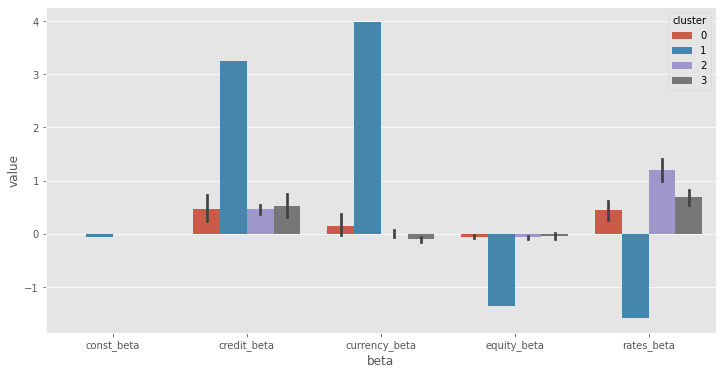

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='beta', y='value', data=beta_reformatted, hue='cluster')

In [35]:
tval_reformatted = results_with_cluster.set_index('cluster_label')[tval_cols].stack().to_frame().reset_index()
tval_reformatted.columns = ['cluster', 'tval', 'value']

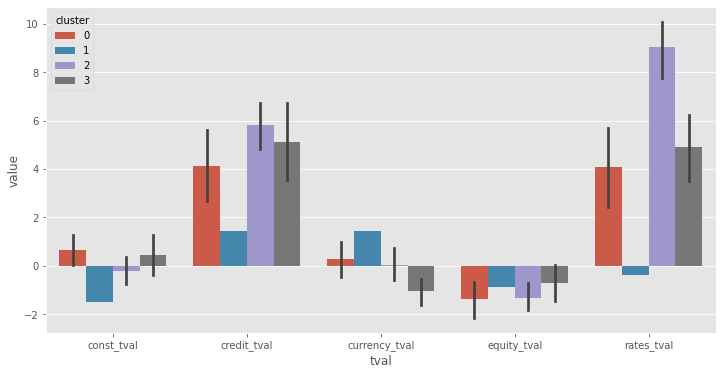

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='tval', y='value', data=tval_reformatted, hue='cluster')

In [38]:
beta_df = results_with_cluster.set_index('country')[beta_cols].T

In [39]:
tval_df = results_with_cluster.set_index('country')[tval_cols].T

In [40]:
def plot_cluster_betas(clusters_df, betas_df, cluster_n, ylim, ytitle):
    # Plot betas for each cluster
    cluster_list = list(clusters_df[clusters_df['cluster_label']==cluster_n]['Countries'])
    betas_df_tmp = betas_df[cluster_list]
    
    #no_const = betas_df_tmp.T[betas_df_tmp.T.columns[~betas_df_tmp.T.columns.isin(['const'])]]
    betas_df_tmp.T.plot(kind='bar', rot=0, figsize=(16,3))
    plt.legend(loc='upper left')
    plt.ylabel(ytitle)
    plt.ylim(-ylim,ylim)

def plot_multiple_clusters(clusters_df, betas_df, ylim, ytitle):
    all_cluster_labels = list(clusters_df['cluster_label'].unique())
    #fig, ax = plt.subplots(nrows=len(all_cluster_labels), constrained_layout=True, figsize=(12,8))
    for label_ in all_cluster_labels:
        plot_cluster_betas(clusters_df, betas_df, label_, ylim, ytitle)

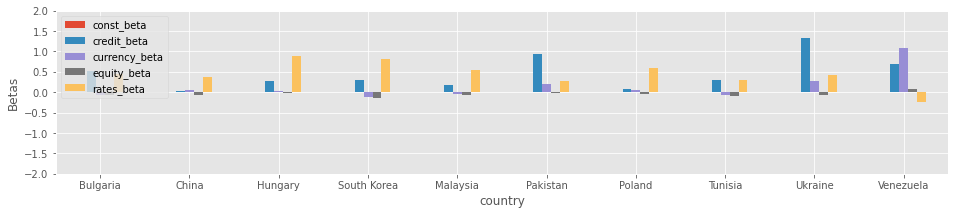

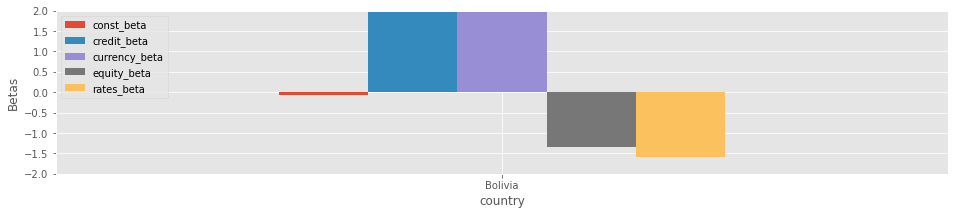

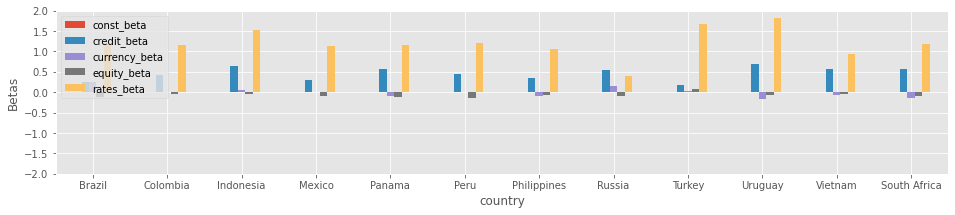

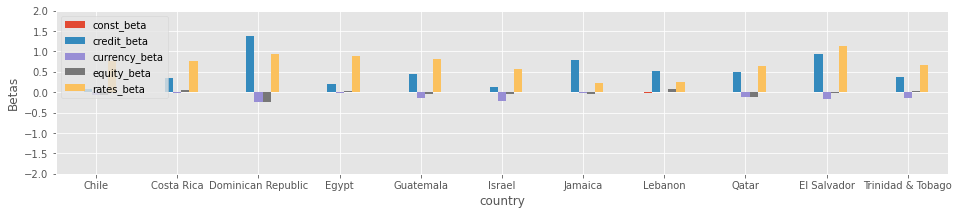

In [41]:
plot_multiple_clusters(results_with_cluster, beta_df, 2, 'Betas')

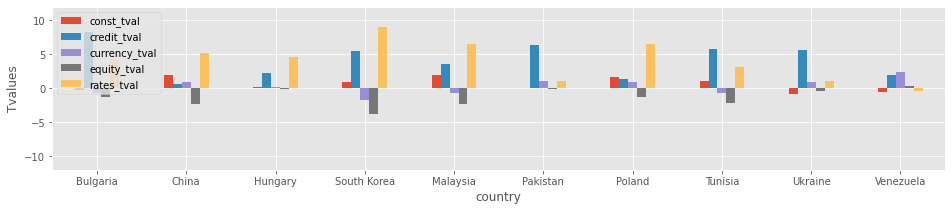

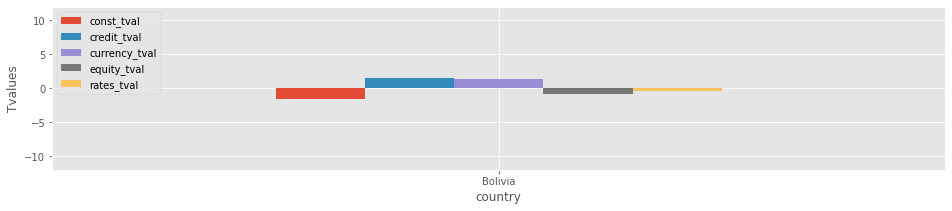

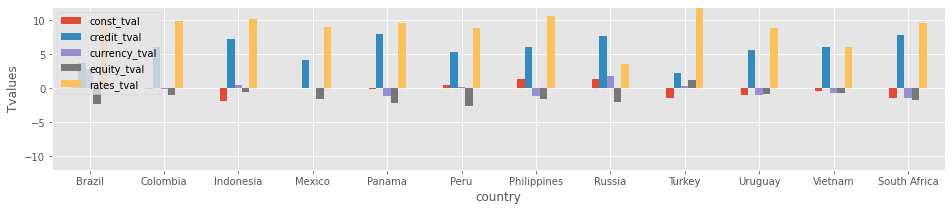

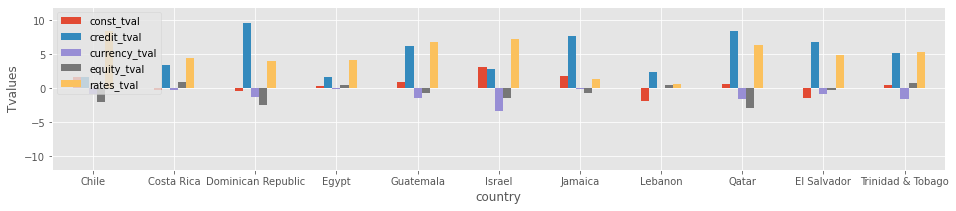

In [42]:
plot_multiple_clusters(results_with_cluster, tval_df, 12, 'Tvalues')